In [ ]:
# installations
!pip install praw
!pip install -U spacy

In [ ]:
# importing modules
import praw
from datetime import datetime 
import tweepy
import time
import pandas as pd
import nltk
import string
import numpy as np
import spacy
import re
import math
from nltk.tokenize.toktok import ToktokTokenizer
import gensim
from gensim.models import LdaModel, CoherenceModel
from gensim import corpora
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.feature_extraction.text 
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [ ]:
# spacy en_core install
!python -m spacy download en_core_web_sm

In [ ]:
# nltk-specific installations
nltk.download('wordnet')
nltk.download('stopwords')

In [ ]:
# nltk-specific setup
from nltk.stem import WordNetLemmatizer
tokenizer = ToktokTokenizer()
from nltk.corpus import stopwords
stopword_list = stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')
nlp = spacy.load("en_core_web_sm")

In [ ]:
# working with R
%load_ext rpy2.ipython

In [ ]:
%%R
install.packages("circlize")
install.packages("ggsci")
install.packages("Hmisc")
install.packages("reshape2")
install.packages("ggpubr")
install.packages("lmtest")

In [ ]:
%%R
# R libraries
library(tidyverse)
library(circlize)
library(ggsci)
library(Hmisc)
library(reshape2)
library(ggpubr)
library(lubridate)
library(lmtest)

# Acquiring Comments

Using PRAW, we created a subreddit instance for r/vancouver.

In [ ]:
# Reddit instance
reddit = praw.Reddit(
    client_id="IfcTjjt_BRBs9g",
    client_secret="Qy6_w-ylNnyrdeIpCIkmKnve8j-VXA",
    user_agent="bigdata2021",
)

# Subreddit instance
van_sub = reddit.subreddit('vancouver')

PRAW can usually only parse and get the most recent 1000 posts in the subreddit. To bypass this, we use its "search" function instead.  

In [ ]:
updates = []
for submission in van_sub.search('Covid-19 Update - ', limit=None):
  updates.append([submission.title, submission.created_utc, submission.id, submission.author])

updates_df = pd.DataFrame(updates, columns=['title', 'time_created', 'id', 'author'])
# print(len(updates_df)) # 250 posts

updates_onlycyc = updates_df[updates_df.author == 'cyclinginvancouver'] # only want the posts by this guy

In [ ]:
# Previewing the data frame
print(updates_onlycyc.head())
updates_onlycyc.to_csv('vancouvermetadata_june14.csv')

All analyses were based on the comments made on the posts. 

In [ ]:
comments = []
ids = updates_onlycyc['id']
for id in ids:
  # print(list(ids).index(id))
  submission = reddit.submission(id=id)
  submission.comments.replace_more(limit=None)
  for comment in submission.comments.list():
    comments.append([comment.author, comment.body, comment.submission.title, comment.replies, comment.score, comment.id, comment.parent_id])

comments_df = pd.DataFrame(comments, columns=['author', 'body', 'sub_title', 'replies', 'score', "ID", "parent_ID"])

In [ ]:
# Previewing the data frame
print(comments_df.head())
# comments_df.to_csv("allcomments_june14.csv")
print(len(comments_df))

# Network Analyses

To understand how Redditors interact with each other, we mapped interactions based on comment replies.

In [ ]:
%%R
comments_df <- read_csv("allcomments_june14.csv")
nrow(comments_df)

In [ ]:
%%R
# Creating an adjacency matrix
## Function for getting authors 
getauthor <- function(ids){
    authors <- c()
    for (id in ids) {
        author <- comments_df %>%
          filter(ID == id) %>%
          select(author) %>%
          pull()
        authors <- c(authors, author)
    }
    return(authors)
}

In [ ]:
%%R
adjacency <- comments_df %>%
  select(author, parent_ID) %>%
  separate(col = parent_ID, into = c("prefix", "parent_ID"), sep = "_") %>%
  filter(prefix != "t3") %>%
  mutate(parent = getauthor(parent_ID)) %>%
  group_by(author, parent) %>%
  dplyr::summarize(count = n()) %>%
  pivot_wider(names_from = parent, values_from = count) %>%
  filter(!is.na(author)) %>%
  column_to_rownames(var = "author") %>%
  as.matrix()

adjacency[is.na(adjacency)] <- 0

# head(adjacency)

In [ ]:
%%R
replies <- comments_df %>%
  select(author, parent_ID) %>%
  separate(col = parent_ID, into = c("prefix", "parent_ID"), sep = "_") %>%
  filter(prefix != "t3") %>%
  nrow()
print(replies) #41962

There are a lot of interactions, but we only want to investigate the top interactors.

In [ ]:
%%R
# how many authors?
nrow(adjacency) # 3887
# how many parents?
ncol(adjacency) # 2992
# too many to plot

In [ ]:
%%R
# distribution of number of interactions per author
rowsum <- adjacency %>%
  as.data.frame() %>%
  rowSums()
author_dist <- adjacency %>%
  as.data.frame() %>%
  mutate(inter_num = rowsum) %>%
  ggplot(aes(x = inter_num)) +
  geom_histogram(bins = 100) +
  theme_minimal() + 
  # coord_cartesian(ylim = c(0, 100)) +
  labs(x="Total Replies Made per Redditor", y="Number of Redditors") +
  theme(axis.text = element_text(size = 12),
        axis.title = element_text(size = 14),
        legend.text = element_text(size = 12),
        legend.title = element_text(size = 14),
        strip.text = element_text(size = 14))
author_dist
ggsave("totalrep.png", plot = author_dist, width = 5, height = 4)

Most people only made less than a handful of comments. Setting my threshold to be greater than 250 comments will eliminate most people. Redditors not meeting this threshold are "Others".

In [ ]:
%%R
# getting authors
threshold_authors <- adjacency %>%
  as.data.frame() %>%
  rownames_to_column(var = "author") %>%
  mutate(inter_num = rowsum) %>%
  filter(rowsum >= 250) %>% # 18 
  select(author) %>%
  pull()

In [ ]:
%%R
# sorting everyone else into "Others"
others <- adjacency %>%
  as.data.frame() %>%
  rownames_to_column(var = "author") %>%
  filter(!(author %in% threshold_authors)) %>%
  column_to_rownames(var = "author") %>%
  colSums()

In [ ]:
%%R
# final data frame
filtered_adjacency <- adjacency %>%
  as.data.frame() %>%
  rownames_to_column(var = "author") %>%
  filter(author %in% threshold_authors) %>%
  column_to_rownames(var = "author") %>%
  rbind(others)
row.names(filtered_adjacency)[19] <- "Others"

In [ ]:
%%R
# distribution of number of interactions per parent
colsum <- filtered_adjacency %>%
  as.data.frame() %>%
  select(-`NA`) %>%
  colSums()
parent_dist <- data.frame("colsum" = colsum) %>%
  ggplot(aes(x = colsum)) +
  geom_histogram(bins = 100) +
  theme_minimal() +
  # coord_cartesian(ylim = c(0, 100)) + 
  labs(x="Replies Received per Redditor", y="Number of Redditors") +
  theme(axis.text = element_text(size = 12),
        axis.title = element_text(size = 14),
        legend.text = element_text(size = 12),
        legend.title = element_text(size = 14),
        strip.text = element_text(size = 14))
parent_dist
ggsave("totalrec.png", plot = parent_dist, width = 5, height = 4)

Most people received very few replies. We chose to set the threshold to 250. Everyone else is "Others".


In [ ]:
%%R
# getting relevant redditors
threshold_parents <- filtered_adjacency %>%
  select_if(function(col) sum(col) >= 250) %>%
  colnames()
threshold_parents

In [ ]:
%%R
# sorting everyone else into Others
other_parents <- filtered_adjacency[, -which(names(filtered_adjacency) %in% threshold_parents)]
filtered_adjacency2 <- other_parents %>%
  mutate(Others = rowSums(other_parents)) %>%
  select(Others) %>%
  cbind(select_if(filtered_adjacency, function(col) sum(col) >= 250))

In [ ]:
%%R
head(filtered_adjacency2)

What proportion of interactions do these people account for?

In [ ]:
%%R
# Replies made
rowsums <- filtered_adjacency2 %>%
  select(-`NA`) %>%
  rowSums()
all <- sum(rowsums)
rowprop <- rowsums / all
print(rowprop)

In [ ]:
%%R
# Replies received
colsums <- filtered_adjacency2 %>%
  select(-`NA`) %>%
  colSums()
all <- sum(colsums)
colprop <- colsums / all
print(colprop)

A chord diagram was used to visualize interactions.

In [ ]:
%%R
adj_mat <- filtered_adjacency2 %>%
  select(-`NA`) %>%
  as.matrix()

In [ ]:
%%R
# saving my plot
svg("interactionmap.svg", width = 960, height = 960)

chordDiagram(adj_mat, annotationTrack = "grid", 
    preAllocateTracks = list(track.height = max(strwidth(unlist(dimnames(adj_mat))))))
circos.track(track.index = 1, panel.fun = function(x, y) {
    circos.text(CELL_META$xcenter, CELL_META$ylim[1], CELL_META$sector.index, 
        facing = "clockwise", niceFacing = TRUE, adj = c(0, 0.5))
}, bg.border = NA) # here set bg.border to NA is important

dev.off()

# Natural Language Processing

In [ ]:
# load in dataset
comments = pd.read_csv("allcomments_june14.csv") #Modify to appropriate file name

## Pre-processing

We need to normalize the text before using it to do anything else.

In [ ]:
# Removing capitals
def no_cap(text):
  lower = [x.lower() for x in text.split(' ')]
  text = ' '.join(lower)
  return text

# Removing special characters incl. numbers
import re

def remove_special_characters(text):
    pattern = r"(@[A-Za-z0-9]+)|([^a-zA-z\s])|(\w+:\/\/\S+)|^rt|http.+?"
    text = re.sub(pattern, '', text)
    return text

# Lemmatizing
def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

# Removing stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

# Complete function
def prepare_text(text):
  text = no_cap(text)
  text = remove_special_characters(text)
  text = lemmatize_text(text)
  text = remove_stopwords(text)
  return text

Applying the function to my comments.

In [ ]:
# Final complete text cleaning
normalized_comments = []
just_comments = comments['body']

for comment in just_comments:
  print(list(just_comments).index(comment))
  clean = prepare_text(comment)
  normalized_comments.append(clean)

In [ ]:
print(normalized_comments[0:5])

In [ ]:
# adding new column to data frame
comments['normalized_body'] = normalized_comments

Some comments are repeats of each other. They may be placeholders for deleted comments, spam, or technical glitches. We want to remove all duplicates. 

In [ ]:
# function for identifying repeats
def Repeat(x):
    _size = len(x)
    repeated = []
    for i in range(_size):
        print(i)
        k = i + 1
        for j in range(k, _size):
            if x[i] == x[j] and x[i] not in repeated:
                repeated.append(x[i])
    return repeated

# getting a list of repeats
comm_list = list(comments['normalized_body'])
duplicated_comments = Repeat(comm_list)

In [ ]:
print(len(duplicated_comments)) #433

In [ ]:
# removing duplicates
filtered_clean_comments = comments[~comments.normalized_body.isin(duplicated_comments)]

In [ ]:
print(len(filtered_clean_comments)) #45303
filtered_clean_comments.to_csv("normalized_nodup_comments_june14.csv")

In [ ]:
print(filtered_clean_comments.head())

## Topic Extraction

We want to understand what people are talking about in the comments.

In [ ]:
# converting to bag of words format
comments = filtered_clean_comments["normalized_body"]
print(comments[0:5])

corpus = []
for comment in comments:
  tokens = []
  for token in gensim.utils.simple_preprocess(comment):
    if len(token) > 3:
      tokens.append(token)
  corpus.append(tokens)
dirichlet_dict = corpora.Dictionary(corpus)
bow_corpus = [dirichlet_dict.doc2bow(text) for text in corpus]

In [ ]:
print(len(corpus))
print(corpus[0:5])

One of the parameters of LDA models is how many topics to have. We want to test a range.

In [ ]:
num_topics = list(range(16)[1:])
num_keywords = 15

LDA_models = {}
LDA_topics = {}
for i in num_topics:
    print(i)
    LDA_models[i] = LdaModel(corpus=bow_corpus,
                             id2word=dirichlet_dict,
                             num_topics=i,
                             update_every=1,
                             chunksize=len(bow_corpus),
                             passes=10,
                             alpha='auto',
                             random_state=42)

    shown_topics = LDA_models[i].show_topics(num_topics=i, 
                                             num_words=num_keywords,
                                             formatted=False)
    LDA_topics[i] = [[word[0] for word in topic[1]] for topic in shown_topics]

To ensure we have distinct topics, we minimize Jaccard similarity.

In [ ]:
def jaccard_similarity(topic_1, topic_2):
    """
    Derives the Jaccard similarity of two topics

    Jaccard similarity:
    - A statistic used for comparing the similarity and diversity of sample sets
    - J(A,B) = (A ∩ B)/(A ∪ B)
    - Goal is low Jaccard scores for coverage of the diverse elements
    """
    intersection = set(topic_1).intersection(set(topic_2))
    union = set(topic_1).union(set(topic_2))
                    
    return float(len(intersection))/float(len(union))

In [ ]:
LDA_stability = {}
for i in range(0, len(num_topics)-1):
    jaccard_sims = []
    for t1, topic1 in enumerate(LDA_topics[num_topics[i]]): # pylint: disable=unused-variable
        sims = []
        for t2, topic2 in enumerate(LDA_topics[num_topics[i+1]]): # pylint: disable=unused-variable
            sims.append(jaccard_similarity(topic1, topic2))    
        
        jaccard_sims.append(sims)    
    
    LDA_stability[num_topics[i]] = jaccard_sims
                
mean_stabilities = [np.array(LDA_stability[i]).mean() for i in num_topics[:-1]]

But we still want coherent topics.

In [ ]:
coherences = [CoherenceModel(model=LDA_models[i], texts=corpus, dictionary=dirichlet_dict, coherence='c_v').get_coherence()\
              for i in num_topics[:-1]]

In [ ]:
print(coherences)
print(mean_stabilities)

In [ ]:
coh_sta_diffs = [coherences[i] - mean_stabilities[i] for i in range(num_keywords)[:-1]] # limit topic numbers to the number of keywords
coh_sta_max = max(coh_sta_diffs)
coh_sta_max_idxs = [i for i, j in enumerate(coh_sta_diffs) if j == coh_sta_max]
ideal_topic_num_index = coh_sta_max_idxs[0] # choose less topics in case there's more than one max
ideal_topic_num = num_topics[ideal_topic_num_index]

Preliminary plot

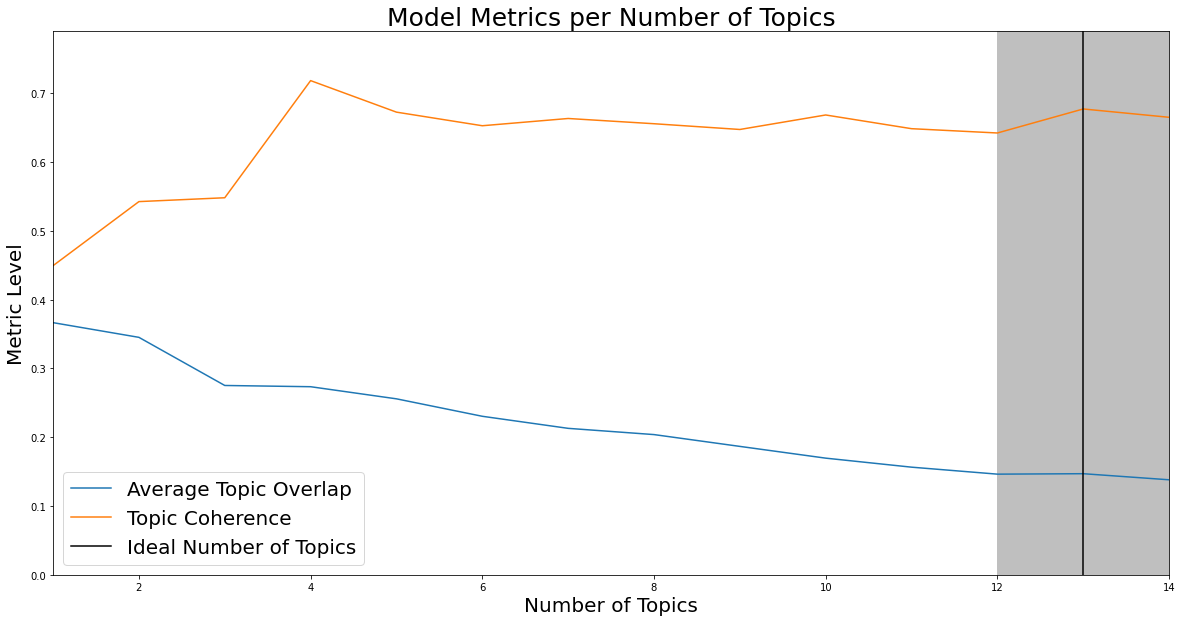

In [ ]:
plt.figure(figsize=(20,10))
ax = sns.lineplot(x=num_topics[:-1], y=mean_stabilities, label='Average Topic Overlap')
ax = sns.lineplot(x=num_topics[:-1], y=coherences, label='Topic Coherence')

ax.axvline(x=ideal_topic_num, label='Ideal Number of Topics', color='black')
ax.axvspan(xmin=ideal_topic_num - 1, xmax=ideal_topic_num + 1, alpha=0.5, facecolor='grey')

y_max = max(max(mean_stabilities), max(coherences)) + (0.10 * max(max(mean_stabilities), max(coherences)))
ax.set_ylim([0, y_max])
ax.set_xlim([1, num_topics[-1]-1])
                
ax.axes.set_title('Model Metrics per Number of Topics', fontsize=25)
ax.set_ylabel('Metric Level', fontsize=20)
ax.set_xlabel('Number of Topics', fontsize=20)
plt.legend(fontsize=20)
plt.show()

Making the final figure in R.

In [ ]:
# getting a data frame for similarity and coherence
cohsim = {'Topic': num_topics[:-1],
          'Coherence': coherences,
          'Similarity': mean_stabilities}
cohsim = pd.DataFrame(cohsim, columns = ['Topic','Coherence', 'Similarity'])
cohsim.to_csv("topicscohsim_june14.csv")

In [ ]:
%%R
# now plotting in R
cohsim <- read_csv("topicscohsim_june14.csv")
colnames(cohsim) <- c("X1", "Topic Coherence", "Number of Topics", "Average Topic Overlap")

cohsim <- cohsim %>%
  pivot_longer(cols = -`Number of Topics`, names_to = "Metric", values_to = "Score")

cohsim_plot <- cohsim %>%
  ggplot(aes(x = `Number of Topics`, y = Score, colour = Metric)) +
  geom_line() +
  xlim(1, 14) +
  ylim(0, 1) +
  theme_minimal() +
  theme(legend.position = c(0.75, 0.4)) +
  scale_colour_nejm() +
  geom_vline(aes(xintercept = 7)) +
  theme(axis.text = element_text(size = 12),
        #axis.text.x = element_text(angle = 90),
        axis.title = element_text(size = 14),
        legend.text = element_text(size = 12),
        legend.title = element_text(size = 14),
        strip.text = element_text(size = 14))
cohsim_plot
ggsave("OptimalTopicR.png", plot = cohsim_plot, width = 5, height = 4)

In [ ]:
%%R
cohsim <- read_csv("topicscohsim_june14.csv")
colnames(cohsim) <- c("X1", "Number of Topics", "Topic Coherence", "Average Topic Overlap")

cohsim <- cohsim %>%
  select(-X1) %>%
  pivot_longer(cols = -`Number of Topics`, names_to = "Metric", values_to = "Score")

cohsim_plot <- cohsim %>%
  ggplot(aes(x = `Number of Topics`, y = Score, colour = Metric)) +
  geom_line() +
  xlim(1, 14) +
  ylim(0, 1) +
  theme_minimal() +
  theme(legend.position = c(0.6, 0.4)) +
  scale_colour_nejm() +
  geom_vline(aes(xintercept = 13)) +
  theme(axis.text = element_text(size = 12),
        #axis.text.x = element_text(angle = 90),
        axis.title = element_text(size = 14),
        legend.text = element_text(size = 12),
        legend.title = element_text(size = 14),
        strip.text = element_text(size = 14))
cohsim_plot
ggsave("OptimalTopicR.png", plot = cohsim_plot, width = 5, height = 4)

Acquiring the top keywords for each topic and topic probabilities for each comment. 

In [ ]:
# Since 13 is the optimal number of topics
lda_13 = LDA_models[13]

In [ ]:
for i,topic in lda_13.show_topics(formatted=True, num_topics=13, num_words=10):
    print(str(i)+": "+ topic)
    print()

0: 0.019*"people" + 0.014*"mask" + 0.010*"contact" + 0.009*"case" + 0.009*"school" + 0.008*"time" + 0.008*"still" + 0.008*"restriction" + 0.007*"like" + 0.007*"well"

1: 0.070*"test" + 0.027*"positive" + 0.019*"people" + 0.016*"outbreak" + 0.015*"testing" + 0.015*"symptom" + 0.012*"exposure" + 0.012*"know" + 0.010*"thank" + 0.010*"result"

2: 0.042*"people" + 0.013*"home" + 0.012*"family" + 0.012*"school" + 0.009*"covid" + 0.009*"work" + 0.009*"spread" + 0.009*"close" + 0.008*"risk" + 0.007*"want"

3: 0.061*"case" + 0.026*"number" + 0.023*"week" + 0.014*"rate" + 0.012*"last" + 0.012*"high" + 0.012*"population" + 0.011*"variant" + 0.011*"death" + 0.010*"hospitalization"

4: 0.080*"care" + 0.048*"facility" + 0.031*"centre" + 0.027*"longterm" + 0.027*"second" + 0.027*"occurrence" + 0.027*"home" + 0.025*"outbreak" + 0.025*"senior" + 0.017*"health"

5: 0.015*"health" + 0.013*"people" + 0.011*"like" + 0.011*"happen" + 0.008*"even" + 0.008*"country" + 0.007*"every" + 0.007*"know" + 0.007*"tim

Word cloud.

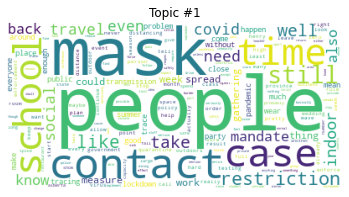

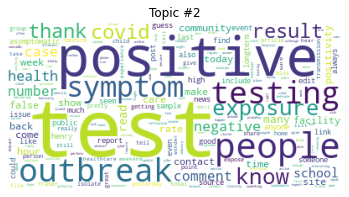

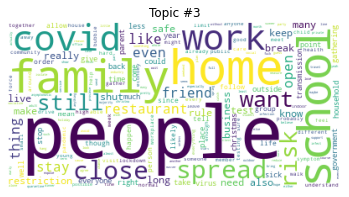

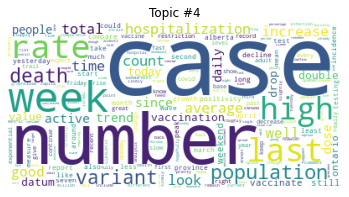

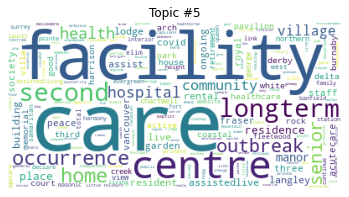

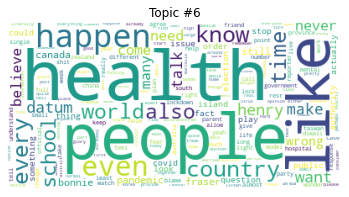

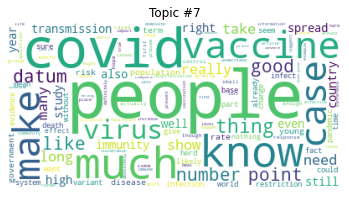

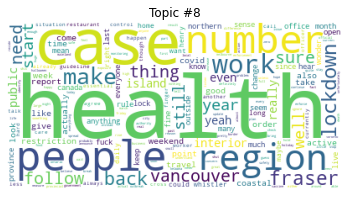

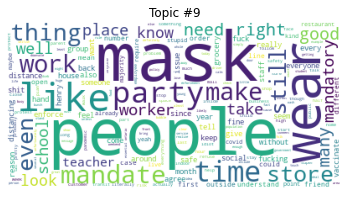

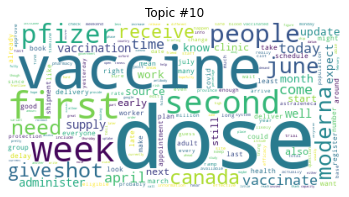

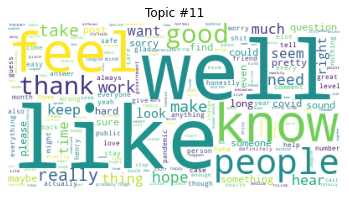

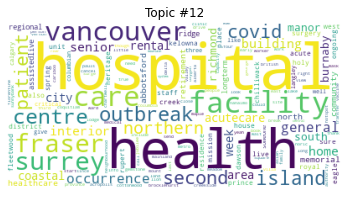

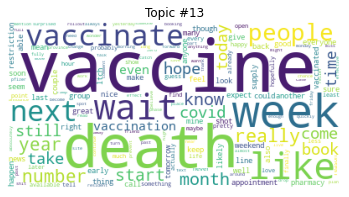

In [ ]:
for t in range(lda_13.num_topics):
    plt.figure()
    plt.imshow(WordCloud(background_color='white').fit_words(dict(lda_13.show_topic(t, 200))))
    plt.axis("off")
    plt.title("Topic #" + str(t + 1))
    plt.show()

Getting a dataframe with topic scores for each comment.

In [ ]:
corpus_lda = lda_13[bow_corpus]
all_topics = lda_13.get_document_topics(corpus_lda, minimum_probability=0.0)
all_topics_csr = gensim.matutils.corpus2csc(corpus_lda)
all_topics_numpy = all_topics_csr.T.toarray()
all_topics_df = pd.DataFrame(all_topics_numpy)

In [ ]:
all_topics_df.to_csv("topic_scores_june14.csv") 

In [ ]:
%%R
comments <- read_csv("normalized_nodup_comments_june14.csv") %>%
  select(-X1, -`Unnamed: 0`)
print(head(comments))
topics <- read_csv("topic_scores_june14.csv") %>%
  select(-X1)
print(head(topics))
comments_topics <- cbind(comments, topics) %>%
  write_csv("comments_topics_june14.csv")

## Sentiment Analysis

### Hydrating Tweets using the Twitter API

To get emotional scores, we used a pre-existing labelled Twitter dataset.

In [ ]:
# set up Twitter API
auth = tweepy.OAuthHandler("uYwv2bUjNmoSw9kpuAVjege6b", "MndeDsR6oxLxt7uCLZWfa4VNe3TS3jRI43KkjvwUQoklvVpjJV")
api = tweepy.API(auth)

In [ ]:
# load in tweets
tweets = pd.read_csv("tweets.csv")
print(tweets.head())

There's a time limit on how many Tweets we can get at once.

In [ ]:
# get tweets
tweet_text900 = []
tweet_text1800 = []
tweet_text2700 = []
tweet_text3600 = []
tweet_text4500 = []
tweet_text5000 = []

tweet_id = list(tweets["tweet_ID"])
for id in tweet_id[0:900]:
  print(tweet_id.index(id))
  try:
    text = api.get_status(id).text
    tweet_text900.append([id, text])
  except:
    pass

In [ ]:
for id in tweet_id[900:1800]:
  print(tweet_id.index(id))
  try:
    text = api.get_status(id).text
    tweet_text1800.append([id, text])
  except:
    pass

time.sleep(900)

for id in tweet_id[1800:2700]:
  print(tweet_id.index(id))
  try:
    text = api.get_status(id).text
    tweet_text2700.append([id, text])
  except:
    pass

time.sleep(900)

for id in tweet_id[2700:3600]:
  print(tweet_id.index(id))
  try:
    text = api.get_status(id).text
    tweet_text3600.append([id, text])
  except:
    pass

time.sleep(900)

for id in tweet_id[3600:4500]:
  print(tweet_id.index(id))
  try:
    text = api.get_status(id).text
    tweet_text4500.append([id, text])
  except:
    pass

time.sleep(900)

for id in tweet_id[4500:5000]:
  print(tweet_id.index(id))
  try:
    text = api.get_status(id).text
    tweet_text5000.append([id, text])
  except:
    pass

In [ ]:
# Combine them all
tweet_text900_df = pd.DataFrame(tweet_text900, columns = ["tweet_ID", "Text"])
tweet_text1800_df = pd.DataFrame(tweet_text1800, columns = ["tweet_ID", "Text"])
tweet_text2700_df = pd.DataFrame(tweet_text2700, columns = ["tweet_ID", "Text"])
tweet_text3600_df = pd.DataFrame(tweet_text3600, columns = ["tweet_ID", "Text"])
tweet_text4500_df = pd.DataFrame(tweet_text4500, columns = ["tweet_ID", "Text"])
tweet_text5000_df = pd.DataFrame(tweet_text5000, columns = ["tweet_ID", "Text"])

tweet_text = pd.concat([tweet_text900_df, tweet_text1800_df, tweet_text2700_df,
                        tweet_text3600_df, tweet_text4500_df, tweet_text5000_df],
                       ignore_index=True)
print(len(tweet_text))

We cleaned the Tweets using the same pipeline as for the Reddit comments.

In [ ]:
clean_tweets = []

for tweet in list(tweet_text['Text']):
  print(list(tweet_text['Text']).index(tweet))
  cleaned = prepare_text(tweet)
  clean_tweets.append(cleaned)

tweet_text['clean'] = clean_tweets
clean_df = pd.merge(tweet_text, tweets, on='tweet_ID')

### Setting up the Model

We will be using a random forest regression model to predict emotional scores.

In [ ]:
# Pipeline w/ Random Forest
from sklearn.ensemble import RandomForestRegressor
tfidf_vec = Pipeline([('tfidf_vec', TfidfVectorizer())])
tfidf = Pipeline([('tfidf', TfidfTransformer())])
preprocess = Pipeline([
    ('tfidf_vec', tfidf_vec),
    ('tfidf', tfidf)
])
pipe = Pipeline([
    ('preprocess', preprocess),
    ('clf', RandomForestRegressor())
])

Applying it to Reddit comments for each emotion.

In [ ]:
# clean_df.to_csv("clean_tweets.csv")
clean_df = pd.read_csv("clean_tweets.csv")
comments = pd.read_csv("comments_topics_june14.csv")

In [ ]:
# For anger intensity
# Train test split
X = clean_df.clean.values.astype('U')
y = clean_df.anger_intensity # change this line to change columns

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

pipe.fit(X_train, y_train)
y_hat0 = pipe.predict(X_test)
rmse1 = math.sqrt(mean_squared_error(y_test, y_hat0))

# For Reddit
redditX = comments.normalized_body.values.astype('U')
anger_reddit = pipe.predict(redditX)
print(rmse1, anger_reddit[1:5])

In [ ]:
# For fear intensity
# Train test split
X = clean_df.clean.values.astype('U')
y = clean_df.fear_intensity # change this line to change columns

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

pipe.fit(X_train, y_train)
y_hat0 = pipe.predict(X_test)
rmse1 = math.sqrt(mean_squared_error(y_test, y_hat0))

# For Reddit
fear_reddit = pipe.predict(redditX)
print(rmse1, fear_reddit[1:5])

In [ ]:
# For sadness intensity
# Train test split
X = clean_df.clean.values.astype('U')
y = clean_df.sadness_intensity # change this line to change columns

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

pipe.fit(X_train, y_train)
y_hat0 = pipe.predict(X_test)
rmse1 = math.sqrt(mean_squared_error(y_test, y_hat0))

# For Reddit
sad_reddit = pipe.predict(redditX)
print(rmse1, sad_reddit[1:5])

In [ ]:
# For joy intensity
# Train test split
X = clean_df.clean.values.astype('U')
y = clean_df.joy_intensity # change this line to change columns

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

pipe.fit(X_train, y_train)
y_hat0 = pipe.predict(X_test)
rmse1 = math.sqrt(mean_squared_error(y_test, y_hat0))

# For Reddit
joy_reddit = pipe.predict(redditX)
print(rmse1, joy_reddit[1:5])

In [ ]:
# Adding columns
comments["anger"] = anger_reddit
comments["fear"] = fear_reddit
comments["sad"] = sad_reddit
comments["joy"] = joy_reddit
comments.to_csv("alldata_vancouver_june14.csv")

# Asking Bigger Questions



In [ ]:
%%R
#Checking the data
ogdata <- read_csv("alldata_vancouver_june14.csv")
print(head(ogdata))

## Engagement Over Time

## Correlation between Topics and Sentiments

There are 13 topics, but there seems to be common themes based on the word clouds. We compress topics into themes based on correlation between topic scores, and our own judgement. 

In [ ]:
%%R
# making a correlation matrix
topics <- ogdata %>%
  select(`0`:`12`) %>%
  sapply(as.numeric)
colnames(topics) <- c("topic1", "topic2", "topic3", "topic4", "topic5", "topic6",
                      "topic7", "topic8", "topic9", "topic10", "topic11", "topic12", "topic13")

c <- rcorr(topics, type = "spearman")$r %>%
  round(2)
p <- rcorr(topics, type = "spearman")$P %>%
  round(2)

In [ ]:
%%R
print(c)
print(p)

Next, we plot this in a heatmap.

In [ ]:
%%R
#Get lower triangle
get_lower_tri <- function(cormat){
    cormat[lower.tri(cormat)]<- NA
    return(cormat)
  }
lower_c <- get_lower_tri(c)
lower_p <- get_lower_tri(p)

melted_c <- melt(lower_c, na.rm = TRUE)
melted_p <- melt(lower_p, na.rm = TRUE)

colnames(melted_c) <- c("Variable1", "Variable2", "Correlation")
colnames(melted_p) <- c("Variable1", "Variable2", "P")
melted_cormat <- merge(melted_c, melted_p, by=c("Variable1", "Variable2"))

ggplot(data = melted_cormat, aes(Variable2, Variable1, fill = Correlation))+
 geom_tile(color = "white")+
 scale_fill_gradient2(low = "#bc3c27", high = "#0072b5", 
   midpoint = 0, limit = c(-1,1), space = "Lab", 
   name="Correlation Coefficient") +
  theme_minimal()+ 
 theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1))+
 coord_fixed() +
  geom_text(aes(Variable2, Variable1, label = Correlation), color = "black", size = 4) +
theme(
  axis.title.x = element_blank(),
  axis.title.y = element_blank(),
  panel.grid.major = element_blank(),
  panel.border = element_blank(),
  panel.background = element_blank(),
  axis.ticks = element_blank(),
  legend.justification = c(1, 0),
  legend.position = c(0.6, 0.8),
  legend.direction = "horizontal",
  legend.text = element_text(size = 12),
  legend.title = element_text(size = 16),
  axis.text = element_text(size = 12))+
  guides(fill = guide_colorbar(barwidth = 10, barheight = 1,
                title.position = "top", title.hjust = 0.5))
# ggsave("TopicsCorrelation.png", width = 5, height = 5)

We end up only merging 5, 6, 8, and 12, which all talk about outbreaks in healthcare contexts. 



In [ ]:
%%R
# averaging topic values
ogdata_merged <- ogdata %>%
  mutate(`13` = pmax(`4`,`5`,`7`,`11`)) %>%
  select(-c(`4`,`5`,`7`,`11`))
print(glimpse(ogdata_merged))

Do people like to talk about 1 topic, or multiple? What about comments?

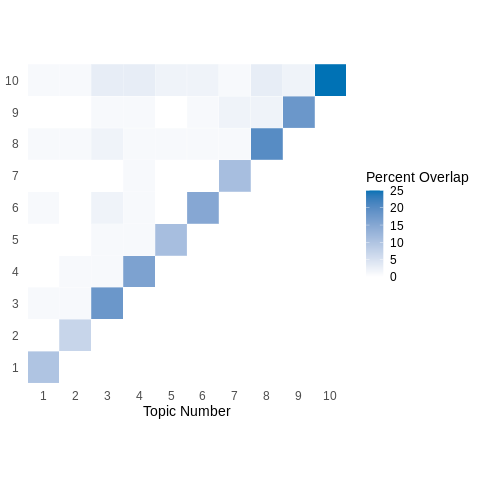

In [ ]:
%%R
# If the topic score is greater than 0.2, then "1"
# function for converting into 1's and 0's 
convert10 <- function(vector){
  vector <- ifelse(vector >= 0.2, 1, 0)
  return(vector)
}

get_lower_tri <- function(cormat){
    cormat[lower.tri(cormat)]<- NA
    return(cormat)
  }

yesno_redditors <- ogdata_merged %>%
  dplyr::select(author, `0`:`13`, -c(anger, fear, sad, joy)) %>%
  `colnames<-`(c('author', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10')) %>%
  group_by(author) %>%
  dplyr::summarize(across(everything(), mean)) %>%
  ungroup() %>%
  dplyr::select(-author) %>%
  sapply(convert10) %>%
  crossprod()
yesnoauthor_perc <- floor(t(yesno_redditors * 100 / length(unique(ogdata_merged$author))))

# plotting the matrix
yesno_authors_plot <- yesnoauthor_perc %>%
  t() %>%
  get_lower_tri() %>%
  melt(na.rm = TRUE) %>%
  as.data.frame() %>%
  ggplot(aes(x = as.factor(Var1), y = as.factor(Var2), fill = `value`)) +
  geom_tile(color = "white") + 
  theme_minimal()+
  coord_fixed() +
  labs(x = "Topic Number", y = NULL, fill = "Percent Overlap") +
  scale_fill_gradient2(low = "white", high = "#0072b5") +
  theme(axis.text = element_text(size = 12),
        #axis.text.x = element_text(angle = 90),
        panel.grid.major = element_blank(),
        panel.border = element_blank(),
        panel.background = element_blank(),
        axis.ticks = element_blank(),
        axis.title = element_text(size = 14),
        legend.text = element_text(size = 12),
        legend.title = element_text(size = 14),
        strip.text = element_text(size = 14)) 
yesno_authors_plot

In [ ]:
%%R
ggsave("authortopicoverlap.png", plot = yesno_authors_plot, width = 5, height = 5)

Since our sentiment analysis data is based on Twitter data, we want to perform a sanity check. 

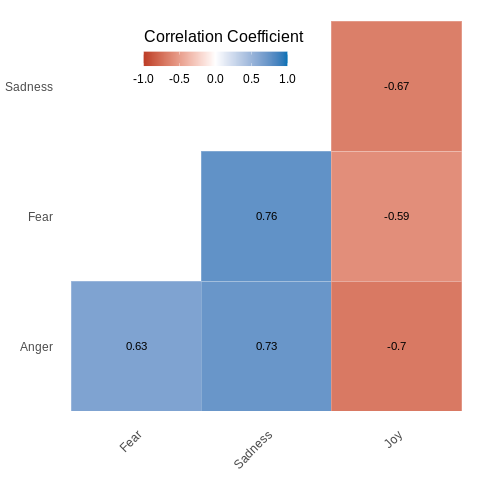

In [ ]:
%%R
# checking correlations between sentiments
emotions <- ogdata %>%
  dplyr::select(anger, fear, sad, joy) %>%
  sapply(as.numeric)

colnames(emotions) <- c("Anger", "Fear", "Sadness", "Joy")

# Correlation matrix
c <- rcorr(emotions, type = "spearman")$r %>%
  round(2)
c
p <- rcorr(emotions,  type = "spearman")$P %>%
  round(2)
p

#Get lower triangle
get_lower_tri <- function(cormat){
    cormat[lower.tri(cormat)]<- NA
    return(cormat)
  }
lower_c <- get_lower_tri(c)

melted_c <- melt(lower_c, na.rm = TRUE)

colnames(melted_c) <- c("Variable1", "Variable2", "Correlation")

senticorr_plot <- melted_c %>%
  filter(Variable1 != Variable2) %>%
  ggplot(aes(Variable2, Variable1, fill = Correlation))+
  geom_tile(color = "white")+
  scale_fill_gradient2(low = "#bc3c27", high = "#0072b5", 
   midpoint = 0, limit = c(-1,1), space = "Lab", 
   name="Correlation Coefficient") +
  theme_minimal()+ 
 theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1))+
 coord_fixed() +
  geom_text(aes(Variable2, Variable1, label = Correlation), color = "black", size = 4) +
theme(
  axis.title.x = element_blank(),
  axis.title.y = element_blank(),
  panel.grid.major = element_blank(),
  panel.border = element_blank(),
  panel.background = element_blank(),
  axis.ticks = element_blank(),
  legend.justification = c(1, 0),
  legend.position = c(0.6, 0.8),
  legend.direction = "horizontal",
  legend.text = element_text(size = 12),
  legend.title = element_text(size = 16),
  axis.text = element_text(size = 12))+
  guides(fill = guide_colorbar(barwidth = 10, barheight = 1,
                title.position = "top", title.hjust = 0.5))
senticorr_plot

In [ ]:
%%R
ggsave("senticorr.png", plot = senticorr_plot, width = 5, height = 5)

## Comparing Prolific Commenters

We generated a PCoA plot to see how the most prolific commenters compared against each other.

In [ ]:
%%R
# getting the list of authors
prolific <- ogdata %>%
  group_by(author) %>%
  dplyr::summarize(count = n()) %>%
  arrange(desc(count)) %>%
  filter(!is.na(author)) %>%
  head(5) %>%
  select(author) %>%
  pull()
print(prolific)

In [ ]:
%%R
# getting Euclidean distances
dist <- ogdata_merged %>%
  filter(author %in% prolific) %>%
  select(`0`, `1`, `2`, `3`, `6`, `8`, `9`, `10`, `12`, `13`) %>%
  dist(method = "euclidean")

In [ ]:
%%R
# preparing my PCoA data frame
pcoa <- cmdscale(dist, k =2)

In [ ]:
%%R
pcoa <- as.data.frame(pcoa)
pcoa$Author <- ogdata %>%
  filter(author %in% prolific) %>%
  select(author) %>%
  pull()
names(pcoa)[1:2] <- c('PC1', 'PC2')

In [ ]:
%%R
# plotting my pcoa plot
plot <- ggplot(pcoa, aes(x = PC1, y = PC2, colour = Author)) +
  # geom_point(alpha = 0.4, size = 0.5) +
  geom_jitter(alpha = 0.4, size = 1) +
  scale_colour_nejm() +
  theme(axis.text = element_text(size = 12),
        #axis.text.x = element_text(angle = 90),
        axis.title = element_text(size = 14),
        legend.text = element_text(size = 12),
        legend.title = element_text(size = 14),
        strip.text = element_text(size = 14)) +
  theme_minimal()

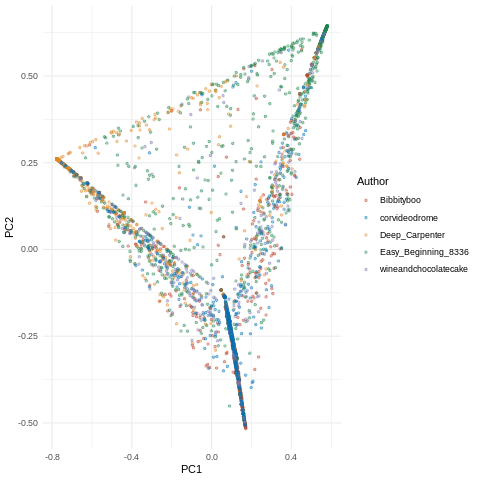

In [ ]:
%%R
plot
# ggsave("TopicPCoA.png", plot = plot, width = 5, height = 4)

They can be somewhat clearly divided by topic, but which ones?

In [ ]:
%%R
# creating boxplots to find out
author_topics <- ogdata_merged %>%
  select(author, `0`, `1`, `2`, `3`, `6`, `8`, `9`, `10`, `12`, `13`) %>%
  filter(author %in% prolific)

colnames(author_topics) <- c("Author", "Topic1", "Topic2", "Topic3", "Topic4", "Topic5",
                             "Topic6", "Topic7", "Topic8", "Topic9", "Topic10")

authortopics <- author_topics %>%
  pivot_longer(cols = -Author, names_to = "Topic", values_to = "Score")
authortopics$Topic <- factor(authortopics$Topic, levels = c("Topic1", "Topic2", "Topic3", "Topic4", "Topic5",
                             "Topic6", "Topic7", "Topic8", "Topic9", "Topic10"))
  
authortopics_plot <- authortopics  %>%
  ggplot(aes(x = Author, y = log10(Score))) +
  geom_boxplot() +
  facet_wrap(~Topic, ncol = 2) +
  theme_minimal() +
  ylim(-4, 0.5) +
  stat_compare_means((aes(group = Author)), method = "anova", 
                     label = "p.format", label.y.npc = 0.95, label.x = 1.3, size = 5) +
  theme(axis.text = element_text(size = 12),
        # axis.title.y = element_text(color = "#bc3c27"),
        # axis.title.y.right = element_text(color = "#0072b5"),
        axis.text.x = element_text(angle = 90),
        axis.title = element_text(size = 14),
        legend.text = element_text(size = 12),
        legend.title = element_text(size = 14),
        strip.text = element_text(size = 14))

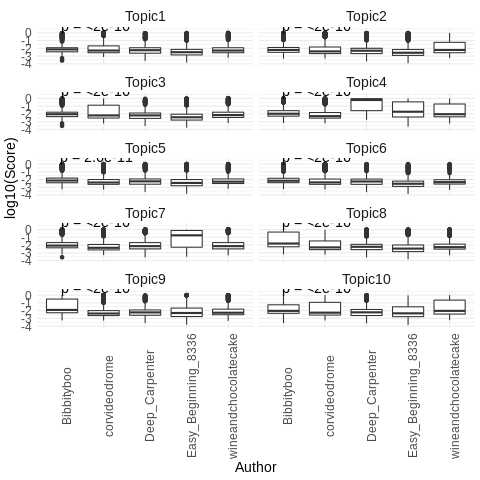

In [ ]:
%%R
authortopics_plot
# ggsave("AuthorTopicComp.png", plot = authortopics_plot, width = 5, height = 20)

It may also be worthwhile to understand differences in emotions and how much people agree with them. 

In [ ]:
%%R
# emotions
author_emotions <- ogdata %>%
  select(author, anger:joy) %>%
  filter(author %in% prolific)

colnames(author_emotions) = c("Author", "Anger", "Fear", "Sadness", "Joy")

authoremotions_plot <- author_emotions %>%
  pivot_longer(cols = -Author, names_to = "Emotion", values_to = "Score")  %>%
  ggplot(aes(x = Author, y = Score)) +
  geom_boxplot() +
  facet_wrap(~Emotion, ncol = 2) +
  theme_minimal() +
  # ylim(-4, 0.5) +
  stat_compare_means((aes(group = Author)), method = "anova", 
                     label = "p.format", label.y.npc = 0.95, label.x = 1.3, size = 5) +
  theme(axis.text = element_text(size = 12),
        # axis.title.y = element_text(color = "#bc3c27"),
        # axis.title.y.right = element_text(color = "#0072b5"),
        axis.text.x = element_text(angle = 90),
        axis.title = element_text(size = 14),
        legend.text = element_text(size = 12),
        legend.title = element_text(size = 14),
        strip.text = element_text(size = 14))

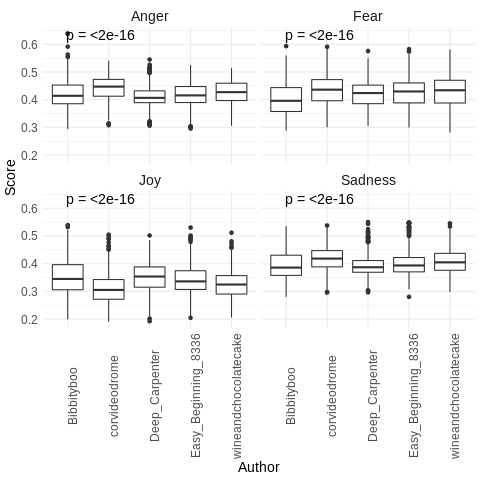

In [ ]:
%%R
authoremotions_plot

In [ ]:
%%R
# agreement as a measure of upvotes and downvotes
author_votes <- ogdata %>%
  select(author, score) %>%
  filter(author %in% prolific)

colnames(author_votes) = c("Author", "Votes")

comparisons <- list(c("Easy_Beginning_8336", "Deep_Carpenter"), c("Easy_Beginning_8336", "corvideodrome"), c("Easy_Beginning_8336", "Bibbityboo"), c("Easy_Beginning_8336", "wineandchocolatecake"),
                    c("Deep_Carpenter", "corvideodrome"), c("Deep_Carpenter", "Bibbityboo"), c("Deep_Carpenter", "wineandchocolatecake"),
                    c("corvideodrome", "Bibbityboo"), c("corvideodrome", "wineandchocolatecake"),
                    c("Bibbityboo", "wineandchocolatecake"))

authorvotes_plot <- author_votes %>%
  ggplot(aes(x = Author, y = log2(Votes))) +
  geom_boxplot() +
  theme_minimal() +
  # ylim(-4, 0.5) +
  stat_compare_means(comparisons = comparisons, method = "wilcox", 
                     label = "p.format", label.y.npc = 0.95, label.x = 1.3, size = 5) +
  theme(axis.text = element_text(size = 12),
        # axis.title.y = element_text(color = "#bc3c27"),
        # axis.title.y.right = element_text(color = "#0072b5"),
        axis.text.x = element_text(angle = 90),
        axis.title = element_text(size = 14),
        legend.text = element_text(size = 12),
        legend.title = element_text(size = 14),
        strip.text = element_text(size = 14))

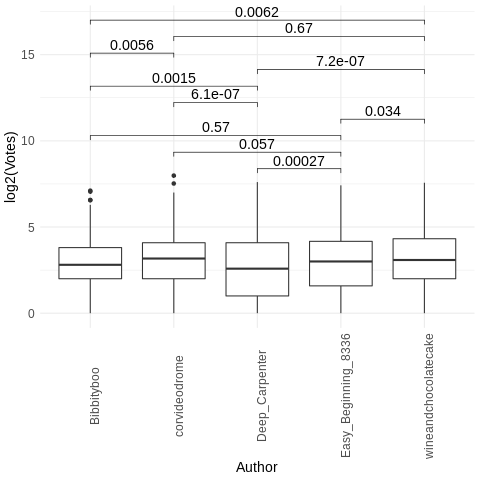

In [ ]:
%%R
authorvotes_plot

## Sentiments Over Time

In [ ]:
%%R
# Getting the date that the comment was posted 
meta <- read_csv("vancouvermetadata_june14.csv")
date <- meta %>%
  mutate(date = as_datetime(time_created)) %>%
  separate(col = date, into = c("date", "time"), sep = " ") %>%
  select(title, date)

ogdata_date <- inner_join(ogdata_merged, date, by = c("sub_title" = "title"))

In [ ]:
%%R
print(glimpse(ogdata_date))

Plotting sentiments over time.

`summarise()` has grouped output by 'date'. You can override using the `.groups` argument.


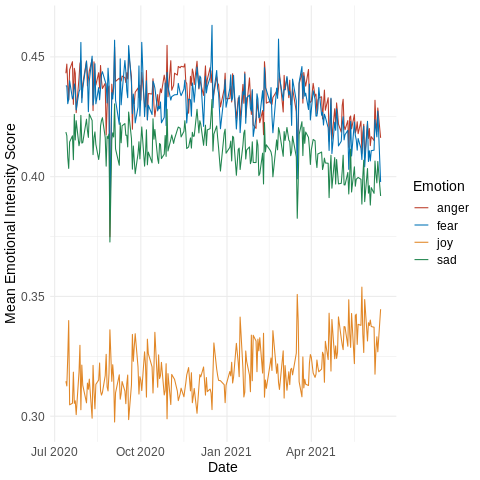

In [ ]:
%%R
comments_longer <- ogdata_date %>%
  pivot_longer(cols = anger:joy, names_to = "Emotion", values_to = "Score")

emotions_overtime_plot <- comments_longer %>%
  group_by(date, Emotion) %>%
  dplyr::summarize(mean_score = mean(Score)) %>%
  ggplot(aes(x = as.Date(date), y = mean_score, colour = Emotion)) +
  geom_line() +
  labs(x = "Date", y = "Mean Emotional Intensity Score") +
  theme_minimal() +
  theme(axis.text = element_text(size = 12),
        axis.title = element_text(size = 14),
        legend.text = element_text(size = 12),
        legend.title = element_text(size = 14),
        strip.text = element_text(size = 14)) +
  scale_colour_nejm()
emotions_overtime_plot

In [ ]:
%%R
ggsave("sentiovertime.png", plot = emotions_overtime_plot, width = 5, height = 4)

## Vaccine-related Discussion and Sentiments

Bibbityboo and Easy_Beginning_8336 both talk about vaccines, but they talk about them in different contexts. Let's look at how the two contexts compare over time.


── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  province = col_character(),
  last_updated = col_character(),
  `data » date` = col_date(format = "")
)
ℹ Use `spec()` for the full column specifications.



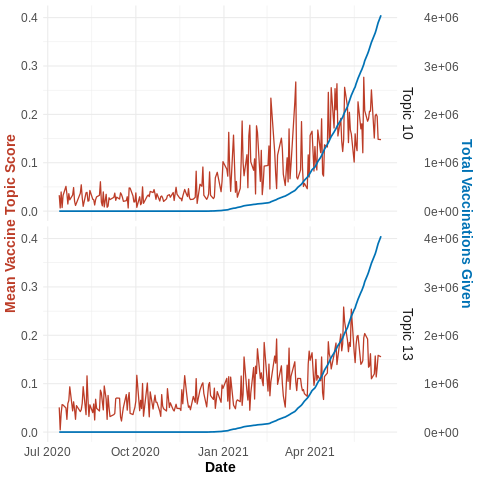

In [ ]:
%%R
# data on new cases
bcdata <- read_csv("bcdata_june14.csv")
vaccine <- bcdata %>%
  dplyr::select("data » date", "data » total_vaccinations")
colnames(vaccine) <- c("Date", "total_vaccinations")

# plotting over time
vaccinetime <- ogdata_date %>%
  mutate(Date = as.Date(date)) %>%
  select(Date, `9`, `12`)
colnames(vaccinetime) <- c("Date", "Topic 10", "Topic 13")

vaccinedata <- vaccinetime %>%
  group_by(Date) %>%
  dplyr::summarize(`Topic 10` = mean(`Topic 10`),
                   `Topic 13` = mean(`Topic 13`)) %>%
  inner_join(vaccine, by = "Date")

#vaccinetime2 <- vaccinetime %>%
# group_by(Date) %>%
# dplyr::summarize(Topic7 = mean(Topic7),
#                  Topic9 = mean(Topic9)) %>%
# pivot_longer(cols = -Date, names_to = "Metric", values_to = "Score")

vaccinegiventopic_plot <- vaccinedata %>%
  pivot_longer(cols = `Topic 10`:`Topic 13`, names_to = "Topic", values_to = "Score") %>%
  ggplot(aes(x = Date)) +
  theme_minimal() +
  geom_line(aes(y = Score), colour = "#bc3c27", size = 0.6) +
  geom_line(aes(y = total_vaccinations / 10000000), colour = "#0072b5", size = 0.8) +
  facet_grid(Topic~.) +
  scale_y_continuous(
    name = "Mean Vaccine Topic Score",
    sec.axis = sec_axis(~.*10000000, name = "Total Vaccinations Given")
  ) +
  theme(axis.text = element_text(size = 12),
        axis.title.y = element_text(color = "#bc3c27", face = "bold"),
        axis.title.y.right = element_text(color = "#0072b5"),
        #axis.text.x = element_text(angle = 90),
        axis.title = element_text(size = 14, face = "bold"),
        legend.text = element_text(size = 12),
        legend.title = element_text(size = 14),
        strip.text = element_text(size = 14))
vaccinegiventopic_plot

In [ ]:
%%R
ggsave("topicvax.png", plot = vaccinegiventopic_plot, width = 5, height = 8)

How correlated are they?

In [ ]:
%%R
topic7_grange <- grangertest(vaccinedata$Topic7, vaccinedata$total_vaccinations)
topic9_grange <- grangertest(vaccinedata$Topic9, vaccinedata$total_vaccinations)
print(topic7_grange)
print(topic9_grange)

Granger causality test

Model 1: vaccinedata$total_vaccinations ~ Lags(vaccinedata$total_vaccinations, 1:1) + Lags(vaccinedata$Topic7, 1:1)
Model 2: vaccinedata$total_vaccinations ~ Lags(vaccinedata$total_vaccinations, 1:1)
  Res.Df Df      F    Pr(>F)    
1    223                        
2    224 -1 17.342 4.462e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Granger causality test

Model 1: vaccinedata$total_vaccinations ~ Lags(vaccinedata$total_vaccinations, 1:1) + Lags(vaccinedata$Topic9, 1:1)
Model 2: vaccinedata$total_vaccinations ~ Lags(vaccinedata$total_vaccinations, 1:1)
  Res.Df Df      F    Pr(>F)    
1    223                        
2    224 -1 13.167 0.0003532 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Do these two vaccine topics differ in terms of sentiment?

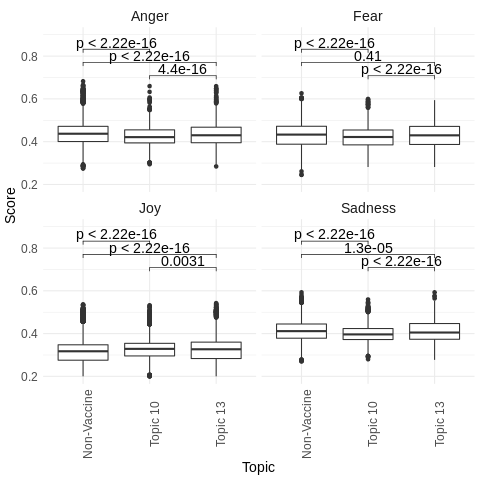

In [ ]:
%%R
vaccorno <- ogdata %>%
  mutate(Topic = ifelse(`9` > 0.2,
                        ifelse(`12` > 0.2,
                               ifelse(`9` > `12`, "Topic 10", "Topic 13"),
                               "Topic 10"),
                        ifelse(`12` > 0.2, "Topic 13", "Non-Vaccine"))) %>%
  select(score, Topic, anger:joy) %>%
  `colnames<-`(c("Upvotes", "Topic", "Anger", "Fear", "Sadness", "Joy")) %>%
  pivot_longer(cols = -c(Topic, Upvotes), names_to = "Emotion", values_to = "Score")

comparisons <- list(c("Topic 10", "Topic 13"), c("Topic 13", "Non-Vaccine"), c("Topic 10", "Non-Vaccine"))

vaccorno_plot <- vaccorno %>%
  ggplot(aes(x = Topic, y = Score)) +
  geom_boxplot() +
  facet_wrap(~Emotion) +
  theme_minimal() +
  ylim(0.2, 0.9) +
  stat_compare_means(comparisons = comparisons, method = "wilcox", 
                     label = "p.format", label.y.npc = 0.9, label.x = 1.3, size = 5) +
  theme(axis.text = element_text(size = 12),
        # axis.title.y = element_text(color = "#bc3c27"),
        # axis.title.y.right = element_text(color = "#0072b5"),
        axis.text.x = element_text(angle = 90),
        axis.title = element_text(size = 14),
        legend.text = element_text(size = 12),
        legend.title = element_text(size = 14),
        strip.text = element_text(size = 14))
vaccorno_plot

In [ ]:
%%R
ggsave("vaccinesenticomp.png", plot = vaccorno_plot, width = 8, height = 8)

## Loose Ends

In [ ]:
%%R
# Dates and counting Redditors
start_date <-  ogdata_date %>%
  select(date) %>%
  tail()
print(start_date)

num_users <- ogdata_date %>%
  select(author) %>%
  pull() %>%
  unique()
print(length(num_users))

Correlations between new cases and number of comments.

In [ ]:
%%R
cases <- bcdata %>%
  dplyr::select("data » date", "data » change_cases")
colnames(cases) <- c("date", "New Cases")

# data on number of comments
num_comments <- ogdata_date %>%
  select(date) %>%
  mutate(date = as.Date(date)) %>%
  group_by(date) %>%
  dplyr::summarize(Comments = n())

# merging
cases_comments <- inner_join(cases, num_comments, by = "date") %>%
  pivot_longer(cols = -date, names_to = "Metric", values_to = "Number")

In [ ]:
%%R
# plotting
casescomments_plot <- cases_comments %>%
  ggplot(aes(x = date, y = Number, colour = Metric)) +
  geom_line() +
  labs(x = "Date", y = "Number") +
  theme_minimal() +
  theme(axis.text = element_text(size = 12),
        axis.title = element_text(size = 14),
        axis.text.x = element_text(angle = 90),
        legend.text = element_text(size = 12),
        legend.title = element_text(size = 14),
        strip.text = element_text(size = 14)) +
  scale_colour_nejm()

In [ ]:
%%R
casescomments_plot
ggsave("casescommentsplot.png", plot = casescomments_plot, width = 5, height = 4)

In [ ]:
%%R
# correlation plot
casescomments_scatter <- inner_join(cases, num_comments, by = "date") %>%
  ggscatter(x = "New Cases", y = "Comments",
            add = "reg.line", conf.int = TRUE, 
            cor.coef = TRUE, cor.method = "pearson", 
            xlab = "Number of New Cases", 
            ylab = "Number of Comments",
            cor.coef.size = 5) +
  theme_minimal() +
  theme(axis.text = element_text(size = 12),
        axis.title = element_text(size = 14))

In [ ]:
%%R
casescomments_scatter
ggsave("casescommentscorr.png", plot = casescomments_scatter, width = 5, height = 4)